In [37]:
!pip install easyocr

import openpyxl 
import os
import cv2
import pytesseract
from matplotlib import pyplot as plt
# from easyocr import easyocr
from pathlib import Path

pytesseract.pytesseract.tesseract_cmd = "C:\\Program Files\\Tesseract-OCR\\tesseract"


ALPHABET = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
DATASET_PATH = f'dataset'
# READER = easyocr.Reader(['en'])

# shows an image on ipynb
def imshow(img):
    plt.axis('off')
    plt.grid(False)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

  Using cached easyocr-1.7.0-py3-none-any.whl (2.9 MB)
  Using cached torch-2.0.1-cp311-cp311-win_amd64.whl (172.3 MB)
  Using cached torchvision-0.15.2-cp311-cp311-win_amd64.whl (1.2 MB)
  Using cached opencv_python_headless-4.7.0.72-cp37-abi3-win_amd64.whl (38.1 MB)
  Using cached scikit_image-0.21.0-cp311-cp311-win_amd64.whl (22.8 MB)
  Using cached requests-2.31.0-py3-none-any.whl (62 kB)
  Using cached filelock-3.12.2-py3-none-any.whl (10 kB)
  Using cached networkx-3.1-py3-none-any.whl (2.1 MB)
  Using cached Jinja2-3.1.2-py3-none-any.whl (133 kB)
  Using cached imageio-2.31.1-py3-none-any.whl (313 kB)
  Using cached lazy_loader-0.2-py3-none-any.whl (8.6 kB)
  Using cached MarkupSafe-2.1.3-cp311-cp311-win_amd64.whl (17 kB)
  Using cached charset_normalizer-3.1.0-cp311-cp311-win_amd64.whl (96 kB)
  Using cached idna-3.4-py3-none-any.whl (61 kB)
  Using cached certifi-2023.5.7-py3-none-any.whl (156 kB)


ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\vts\\Documents\\GitHub\\smokey-mountain-comp\\.venv\\Lib\\site-packages\\cv2\\cv2.pyd'
Check the permissions.



In [34]:
images = []
for (id, filename) in enumerate(os.listdir(DATASET_PATH)):
    image = cv2.imread(f"{DATASET_PATH}/{filename}")
    images.append((filename, image))

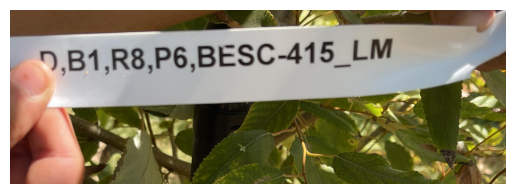

In [36]:
def crop_image(img: cv2.Mat):

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (71, 71), 0)
    ret, thresh = cv2.threshold(blur,150,255,0)
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    big_contour = sorted(contours, key=cv2.contourArea, reverse=True)[0]

    x, y, w, h = cv2.boundingRect(big_contour) 
    newimg = img[y:y+h, x:x+w]

    imshow(newimg)

if __name__ == "__main__":
    crop_image(images[5][1])

In [38]:
for filename, image in images:
    print(pytesseract.image_to_string(image))





4 -
Pia j .
a x A
Me tid)

p


id é
=

: _ if
“ i —#

J ae a”,



KX

i enceal © oh



